<a href="https://colab.research.google.com/github/jjooki/TIL/blob/main/bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Only for colab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/dacon/bike

Mounted at /content/drive


In [10]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 14.1 MB/s 
     |████████████████████████████████| 81 kB 10.7 MB/s 
     |████████████████████████████████| 209 kB 70.5 MB/s 
     |████████████████████████████████| 78 kB 8.3 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 147 kB 70.6 MB/s 
     |████████████████████████████████| 112 kB 93.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=75a4a9da62e39c6f5fbdda069ce090e050c50b46032c46dc6fd9ac415786106c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [16]:
import os
import warnings
warnings.filterwarnings(action='ignore')

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

import itertools
import numpy as np
import pandas as pd
import holidays
from pathlib import Path

base_path = Path('__file__').resolve().parent
train = pd.read_csv(base_path / 'data/train.csv')
submission = pd.read_csv(base_path / 'data/sample_submission.csv')

train['일시'] = pd.to_datetime(train['일시'], format='%Y%m%d')
regions = ['광진구', '동대문구', '성동구', '중랑구']
metric = 'mae'

train

,일시,광진구,동대문구,성동구,중랑구
0,2018-01-01,0.592,0.368,0.580,0.162
1,2018-01-02,0.840,0.614,1.034,0.260
2,2018-01-03,0.828,0.576,0.952,0.288
3,2018-01-04,0.792,0.542,0.914,0.292
4,2018-01-05,0.818,0.602,0.994,0.308
...,...,...,...,...,...
1456,2021-12-27,3.830,3.416,2.908,2.350
1457,2021-12-28,4.510,3.890,3.714,2.700
1458,2021-12-29,4.490,3.524,3.660,2.524
1459,2021-12-30,4.444,3.574,3.530,2.506


In [ ]:
def predict(train, column):
    model = Prophet()
    df = pd.DataFrame()
    df['ds'] = train['일시']
    df['y'] = train[column]
    model.fit(df)
    future = model.make_future_dataframe(periods=334, freq='D')
    forecast = model.predict(future)
    return forecast.loc[1461:, 'yhat'].values

for region in regions:
    submission[region] = predict(train, region)

submission

00:04:16 - cmdstanpy - INFO - Chain [1] start processing
00:04:16 - cmdstanpy - INFO - Chain [1] done processing
00:04:17 - cmdstanpy - INFO - Chain [1] start processing
00:04:17 - cmdstanpy - INFO - Chain [1] done processing
00:04:18 - cmdstanpy - INFO - Chain [1] start processing
00:04:18 - cmdstanpy - INFO - Chain [1] done processing
00:04:19 - cmdstanpy - INFO - Chain [1] start processing
00:04:19 - cmdstanpy - INFO - Chain [1] done processing


,일시,광진구,동대문구,성동구,중랑구
0,20220101,5.117904,4.662310,3.891647,3.305196
1,20220102,4.830105,4.401693,3.764658,3.084157
2,20220103,5.130415,5.152141,4.116836,3.325621
3,20220104,5.249848,5.303368,4.209936,3.450504
4,20220105,5.479869,5.442256,4.365577,3.571414
...,...,...,...,...,...
329,20221126,8.975605,8.007661,6.363887,5.354578
330,20221127,8.588879,7.668365,6.158841,5.072465
331,20221128,8.788668,8.338105,6.432530,5.252610
332,20221129,8.806026,8.406648,6.446620,5.315945


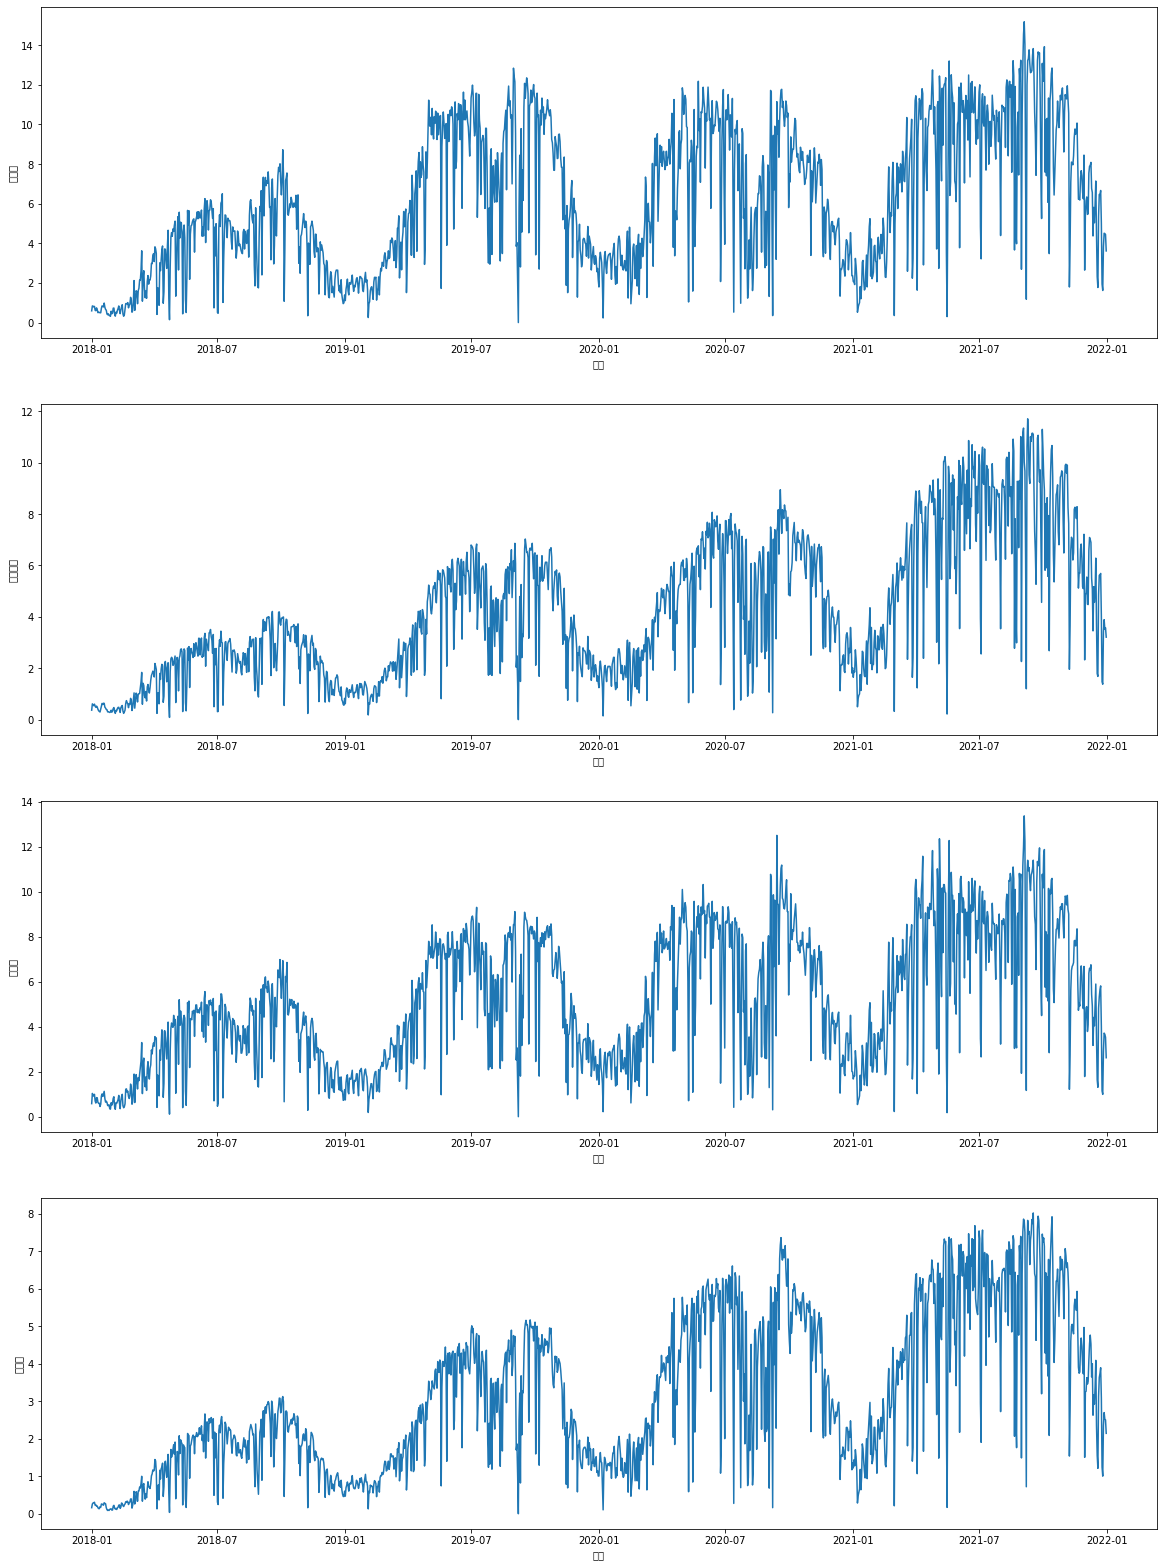

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

_, ax = plt.subplots(4, 1, figsize=(20, 28))
regions = ['광진구', '동대문구', '성동구', '중랑구']
for i in range(4):
    sns.lineplot(train['일시'], train[regions[i]], ci=None, ax=ax[i])
plt.show()

In [9]:
model = Prophet()
df = pd.DataFrame()
df['ds'] = train['일시']
df['y'] = train['동대문구']
model.fit(df)

df_cv = cross_validation(model,
                         initial='730 days',
                         period='30 days',
                         horizon='334 days',
                         parallel="processes")
df_cv

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy87iorjo/ykkpl8ts.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy87iorjo/kd_0pvnk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75453', 'data', 'file=/tmp/tmpy87iorjo/ykkpl8ts.json', 'init=/tmp/tmpy87iorjo/kd_0pvnk.json', 'output', 'file=/tmp/tmpy87iorjo/prophet_modelxvws42em/prophet_model-20221128062913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:29:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:29:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 14 forecasts with cutoffs between 2020-01-07 00:00:00 and 2021-01-31 00:00:00
INFO:prophet:Applying in parallel with <concu

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-01-08,2.384966,1.320879,3.410181,1.568,2020-01-07
1,2020-01-09,2.337530,1.287694,3.445483,2.068,2020-01-07
2,2020-01-10,2.454844,1.405846,3.549872,2.108,2020-01-07
3,2020-01-11,2.202283,1.204582,3.237313,1.758,2020-01-07
4,2020-01-12,1.930807,0.903518,2.943307,1.480,2020-01-07
...,...,...,...,...,...,...
4671,2021-12-27,3.569000,2.171213,4.924038,3.416,2021-01-31
4672,2021-12-28,3.750312,2.278133,5.137202,3.890,2021-01-31
4673,2021-12-29,3.549901,2.088492,5.002749,3.524,2021-01-31
4674,2021-12-30,3.560240,2.052076,5.094892,3.574,2021-01-31


In [15]:
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,34 days,2.098469,1.448609,1.137074,0.540839,0.207048,0.295944,0.572193
1,35 days,2.134502,1.460993,1.147633,0.548959,0.205076,0.299228,0.565158
2,36 days,2.156275,1.468426,1.153195,0.557637,0.207225,0.302178,0.561487
3,37 days,2.141185,1.463279,1.152858,0.531862,0.207225,0.300254,0.557204
4,38 days,2.192408,1.480678,1.161893,0.547323,0.204169,0.302356,0.557204
...,...,...,...,...,...,...,...,...
296,330 days,4.891542,2.211683,1.857118,0.423865,0.283754,0.342909,0.363567
297,331 days,4.965002,2.228228,1.869070,0.425755,0.286577,0.345096,0.364943
298,332 days,5.019748,2.240480,1.879890,0.421619,0.289166,0.347552,0.365096
299,333 days,5.066518,2.250893,1.889200,0.421798,0.293179,0.350567,0.364943


In [14]:
df_p = performance_metrics(df_cv, rolling_window=1)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,334 days,3.879366,1.969611,1.62818,0.504257,0.262599,0.330403,0.408469


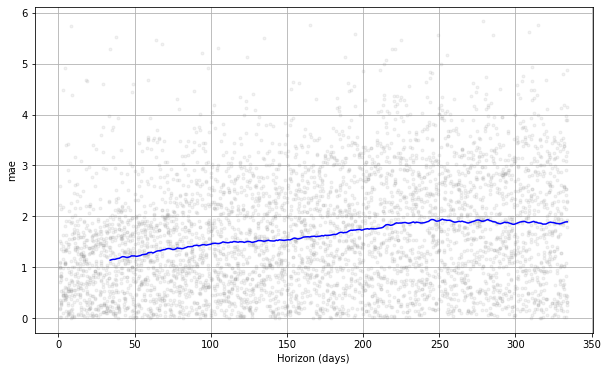

In [13]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [ ]:
"""
Hyper-parameter Tuning with Prophet + GridSearchCV
Tutorial
"""

param_grid = {
    'changepoint_prior_scale': [0.001, 0.5],
    'seasonality_prior_scale': [0.01, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params)
    df = pd.DataFrame()
    df['ds'] = train['일시']
    df['y'] = train['광진구']
    model.fit(df)  # Fit model with given params
    df_cv = cross_validation(model, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
tuning_results

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphixi45b1/d96q2deh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphixi45b1/jegi4vf5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42032', 'data', 'file=/tmp/tmphixi45b1/d96q2deh.json', 'init=/tmp/tmphixi45b1/jegi4vf5.json', 'output', 'file=/tmp/tmphixi45b1/prophet_modelftb5p0gn/prophet_model-20221116051002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:10:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:10:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
05:10:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error duri

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,mae
0,0.001,0.01,additive,3.391536
1,0.001,0.01,multiplicative,4.931583
2,0.001,10.00,additive,2.328944
3,0.001,10.00,multiplicative,1.165524
4,0.500,0.01,additive,1.840568
5,0.500,0.01,multiplicative,2.208075
6,0.500,10.00,additive,1.040603
7,0.500,10.00,multiplicative,1.059634


In [ ]:
tuning_results = tuning_results.sort_values(by=['mae']).reset_index(drop=True)
tuning_results.iloc[0, :-1].to_dict()
# final_param = tuning_results.iloc[0, :-1].to_dict()

{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 10.0,
 'seasonality_mode': 'additive'}

In [ ]:
forecast.loc[1461:, ['ds', 'yhat']]

,ds,yhat
1461,2022-01-01,3.240807
1462,2022-01-02,2.776563
1463,2022-01-03,3.098331
1464,2022-01-04,3.148802
1465,2022-01-05,3.473300
...,...,...
1790,2022-11-26,7.569874
1791,2022-11-27,6.960788
1792,2022-11-28,7.284986
1793,2022-11-29,7.284166


## Prophet + Optuna

In [17]:
import holidays

In [24]:
import optuna
from optuna import Trial

import holidays

def objective(trial, df, param_types, bounds, metric: str=''):
    '''Train a prophet model and return the rmse'''
    # trial method
    methods = {
        'int': trial.suggest_int,
        'float': trial.suggest_float,
        'cat': trial.suggest_categorical,
        'log': trial.suggest_loguniform,
    }
    
    # sampling
    params = {}
    for param, type_ in param_types.items():
        if type_ == 'cat':
            params[param] = methods[type_](param,
                                           bounds[param])
        else:
            params[param] = methods[type_](param,
                                           bounds[param][0],
                                           bounds[param][1])
    # modeling
    model = Prophet(weekly_seasonality=True,
                    daily_seasonality=False,
                    **params)
    
    model.add_country_holidays(country_name='KR')
    model.fit(df)  # Fit model with given params
    # cross_validation
    df_cv = cross_validation(model,
                             initial='730 days',
                             period='30 days',
                             horizon='334 days',
                             parallel="processes")
    # calculate metrics
    df_p = performance_metrics(df_cv, rolling_window=0.1)
    
    return df_p[metric].mean()

In [25]:
def optimized_predict(train, region: str,
                      metric: str, n_trials: int,
                      param_types: dict, bounds: dict):

    df = pd.DataFrame()
    df['ds'] = train['일시']
    df['y'] = train[region]

    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial : objective(trial, df, param_types, bounds, metric),
                   n_trials=n_trials)
    best_params = study.best_params

    # modeling
    model = Prophet(weekly_seasonality=True,
                    daily_seasonality=False,
                    **best_params)
    
    model.add_country_holidays(country_name='KR')
    model.fit(df)
    future = model.make_future_dataframe(periods=334, freq='D')
    forecast = model.predict(future)
    return forecast.loc[len(train):, 'yhat'].values

In [26]:
param_types = {'changepoint_prior_scale': 'log', 
            'seasonality_prior_scale': 'log',
            'holidays_prior_scale': 'log',
            'changepoint_range': 'float',
            'seasonality_mode': 'cat'}

bounds = {'changepoint_prior_scale': [1e-3, 0.5],
        'seasonality_prior_scale': [1e-2, 10],
        'holidays_prior_scale': [1e-2, 10],
        'changepoint_range': [0.8, 0.95],
        'seasonality_mode': ['additive', 'multiplicative']}

for region in regions:
    submission[region] = optimized_predict(train, region,
                                           metric='mae', n_trials=100,
                                           param_types=param_types, bounds=bounds)

submission

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
09:14:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:14:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy87iorjo/43wh_6mk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy87iorjo/lt45ko4l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13794', 'data', 'file=/tmp/tmpy87iorjo/43wh_6mk.json', 'init=/tmp/tmpy87iorjo/lt45ko4l.json', 'output', 'file=/tmp/tmpy87iorjo/prophet_model0e74v_qk/prophet_model-20221128091423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:14:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:14:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdst

,일시,광진구,동대문구,성동구,중랑구
0,20220101,4.967023,2.717194,3.993289,2.193648
1,20220102,4.768470,2.330924,4.013158,1.864431
2,20220103,5.085479,3.345326,4.378468,2.165479
3,20220104,5.181905,3.417541,4.456981,2.250233
4,20220105,5.417957,3.670360,4.610369,2.462948
...,...,...,...,...,...
329,20221126,8.677705,6.276670,6.776843,4.735149
330,20221127,8.298416,5.734756,6.577398,4.261945
331,20221128,8.517824,6.912749,6.867036,4.583356
332,20221129,8.515600,6.970152,6.869681,4.648163


In [27]:
save_path = base_path / 'submission/'

# Check submission file name and define file name
if 'submission_bike.csv' in os.listdir(save_path):
    count = 0
    for name in os.listdir(save_path):
        if 'submission_bike' in name:
            count += 1
    filename = f"submission_bike{count + 1}.csv"
else:
    filename = 'submission_bike.csv'

# Export submission file
submission.to_csv(save_path / filename, index=False)

# Final code

In [ ]:
## Final Code is here!

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

# regression metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error, r2_score

import itertools
import numpy as np
import pandas as pd
import os
import holidays

base_path = '/content/drive/MyDrive/dacon/bike/'

train = pd.read_csv(base_path + 'data/train.csv')
submission = pd.read_csv(base_path + 'data/sample_submission.csv')

train['일시'] = pd.to_datetime(train['일시'], format='%Y%m%d')
regions = ['광진구', '동대문구', '성동구', '중랑구']

In [ ]:
def predict(train, column):
    """
    Basic prediction model
    """
    df = pd.DataFrame()
    df['ds'] = train['일시']
    df['y'] = train[column]
    model = Prophet().fit(df)
    future = model.make_future_dataframe(periods=334, freq='D')
    forecast = model.predict(future)
    return forecast.loc[1461:, 'yhat'].values

In [ ]:
def predict2(train: pd.DataFrame, region: str, param_grid: dict):
    """
    Upgraded prediction model with hyper-parameter tuning
    """
    # Make time series dataframe for each region
    df = pd.DataFrame()
    df['ds'] = train['일시']
    df['y'] = train[region]

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    maes = []  # Store the RMSEs for each params here

    # Use cross validation to evaluate all parameters
    for params in all_params:
        model = Prophet(**params)
        model.fit(df)  # Fit model with given params
        df_cv = cross_validation(model, horizon='365 days', parallel="processes")
        df_p = performance_metrics(df_cv)
        maes.append(df_p['mae'].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['mae'] = maes

    # Sorted by rmes values
    tuning_results = tuning_results.sort_values(by=['mae'])

    # Pick the optimized(having minimum rmse value) hyper-parameter combination
    final_params = tuning_results.iloc[0, :-1].to_dict()

    # Train the final model with optimized params
    m = Prophet(**final_params).fit(df)
    future = m.make_future_dataframe(periods=334, freq='D')
    forecast = m.predict(future)
    
    # Make the predict column for submission
    return final_params, forecast.loc[1461:, 'yhat'].values

In [ ]:
import holidays

holiday = pd.DataFrame([])
for date, name in sorted(holidays.KR(years=[2018, 2019, 2020, 2021, 2022]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "KR-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday

,ds,holiday
0,2018-01-01,KR-Holidays
1,2018-02-15,KR-Holidays
2,2018-02-16,KR-Holidays
3,2018-02-17,KR-Holidays
4,2018-03-01,KR-Holidays
...,...,...
67,2021-10-03,KR-Holidays
68,2021-10-04,KR-Holidays
69,2021-10-09,KR-Holidays
70,2021-10-11,KR-Holidays


In [ ]:
final_params = []
# Set the candidates of hyper-parameters
param_grid = {
    'holidays' : [holiday],
    'changepoint_prior_scale': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}
for region in regions:
    temp, submission[region] = predict2(train, region, param_grid)
    final_params.append(temp)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
INFO:cmdstanpy:Chain [1] start processing
05:46:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2020-12-31 00:00:00 and 2020-12-31 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5c887a7d50>
DEBUG:cmdstanpy:input tempfile: /tmp/tmphixi45b1/16ycjtbl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphixi45b1/2kka7_g4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89581', 'data', 'file=/tmp/tmphixi45b1/16ycjtbl.json', 'init=/tmp/tmphixi45b1/2kka7_g4.json', 'output', 'file=/tmp/tmphixi45b1/prophet_model7x64cew2/prophet_model-20221116054654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:46:54 - cmdstanpy - INFO - Chain [1] start processi

In [ ]:
# Print hyper-parameters after tuning
for region, params in zip(regions, final_params):
    print(f"--------------- Hyper-parameters of {region} ---------------")
    print('changepoint_prior_scale : ', params['changepoint_prior_scale'])
    print('seasonality_prior_scale : ', params['seasonality_prior_scale'])
    print('seasonality_mode        : ', params['seasonality_mode'])

# Check submission file name and define file name
if 'submission_bike.csv' in os.listdir(save_path):
    count = 0
    for name in os.listdir(save_path):
        if 'submission_bike' in name:
            count += 1
    filename = f"submission_bike{count + 1}.csv"
else:
    filename = 'submission_bike.csv'

# Export submission file
submission.to_csv(base_path + 'submission/' + filename, index=False)

--------------- Hyper-parameters of 광진구 ---------------
changepoint_prior_scale :  0.1
seasonality_prior_scale :  5.0
seasonality_mode        :  multiplicative
--------------- Hyper-parameters of 동대문구 ---------------
changepoint_prior_scale :  0.05
seasonality_prior_scale :  1.0
seasonality_mode        :  multiplicative
--------------- Hyper-parameters of 성동구 ---------------
changepoint_prior_scale :  0.1
seasonality_prior_scale :  10.0
seasonality_mode        :  multiplicative
--------------- Hyper-parameters of 중랑구 ---------------
changepoint_prior_scale :  0.005
seasonality_prior_scale :  5.0
seasonality_mode        :  multiplicative


In [ ]:
print(params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
